##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

Modified by Piyakorn Mona Munegan

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from google.colab import drive
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

import tensorflow_hub as hub

import pprint

tf.get_logger().setLevel('ERROR')
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from platform import python_version

print("Current Python Version-", python_version())
print("Current TF Version-", tf.__version__)

Current Python Version- 3.7.13
Current TF Version- 2.8.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 1s 0us/step


In [ ]:
#dataset = '/content/drive/My Drive/COMP8220/Assessed Task 3/'
#dataset_dir = os.path.join(os.path.dirname(dataset), 'data')
#os.chdir(dataset)

In [5]:
os.listdir(dataset_dir)

['test', 'imdb.vocab', 'train', 'README', 'imdbEr.txt']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'unsupBow.feat',
 'neg',
 'unsup',
 'urls_neg.txt',
 'urls_pos.txt',
 'pos',
 'labeledBow.feat']

In [7]:
!ls

aclImdb  aclImdb_v1.tar.gz  drive  sample_data


The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
print(train_ds)
print(val_ds)
print(test_ds)
print("train set size: ", len(train_ds))
print("test set size: ", len(val_ds))
print("validate test set size: ", len(test_ds))

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
train set size:  625
test set size:  157
validate test set size:  782


### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

#### OrigNN

In [22]:
embedding_dim = 16

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [ ]:
epochs = 10
historyOrigNN = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 8s 7ms/step - loss: 0.6633 - binary_accuracy: 0.6971 - val_loss: 0.6133 - val_binary_accuracy: 0.7744
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.5471 - binary_accuracy: 0.8014 - val_loss: 0.4973 - val_binary_accuracy: 0.8232
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.4433 - binary_accuracy: 0.8475 - val_loss: 0.4196 - val_binary_accuracy: 0.8460
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3782 - binary_accuracy: 0.8662 - val_loss: 0.3737 - val_binary_accuracy: 0.8594
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3347 - binary_accuracy: 0.8806 - val_loss: 0.3450 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3037 - binary_accuracy: 0.8884 - val_loss: 0.3259 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3105 - binary_accuracy: 0.8730
Loss:  0.310505211353302
Accuracy:  0.8730000257492065


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [ ]:
history_dict = historyOrigNN.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

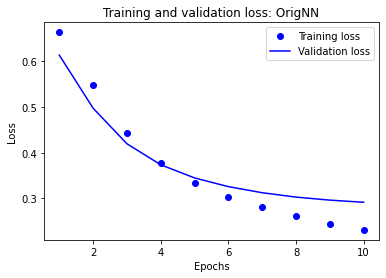

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: OrigNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

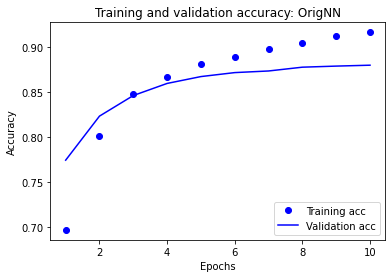

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: OrigNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3105 - accuracy: 0.8730
0.8730000257492065


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6078512 ],
       [0.43045327],
       [0.34703845]], dtype=float32)

In [ ]:
examples

['The movie was great!', 'The movie was okay.', 'The movie was terrible...']

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.


## Model parameters

In [ ]:
#Student ID: 46318461 -> N =1
N = 1
DHL = 100+20*N
D = 0.3 + 0.05 * N
K = (N // 2) + 5

print("Dense hidden layer: ", DHL)
print("Dropout: ", D)
print("Kernel size: ", K)

Dense hidden layer:  120
Dropout:  0.35
Kernel size:  5


## Task 1

Task 1 [1 mark]
Add a Dense hidden layer to the neural net in an appropriate place with (100 + 20 * N) neurons.  Call this network DenseNNi.  In your notebook, compare the performance of DenseNNi with OrigNN, considering the performance at each epoch, not just the final one.

### DenseNNi

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

DenseNNi = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(DHL), #DHL=120
  layers.Dense(1)])

DenseNNi.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

DenseNNi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 120)               2040      
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                        

In [ ]:
epochs = 10
historyDenseNNi = DenseNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4790 - binary_accuracy: 0.7613 - val_loss: 0.3171 - val_binary_accuracy: 0.8694
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2645 - binary_accuracy: 0.8951 - val_loss: 0.2975 - val_binary_accuracy: 0.8760
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2073 - binary_accuracy: 0.9207 - val_loss: 0.3113 - val_binary_accuracy: 0.8742
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1731 - binary_accuracy: 0.9351 - val_loss: 0.3382 - val_binary_accuracy: 0.8688
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1404 - binary_accuracy: 0.9496 - val_loss: 0.3750 - val_binary_accuracy: 0.8696
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1200 - binary_accuracy: 0.9581 - val_loss: 0.4214 - val_binary_accuracy: 0.8694
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [ ]:
loss, accuracy = DenseNNi.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.7916 - binary_accuracy: 0.8366
Loss:  0.791645884513855
Accuracy:  0.8366000056266785


In [ ]:
history_dict = historyDenseNNi.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

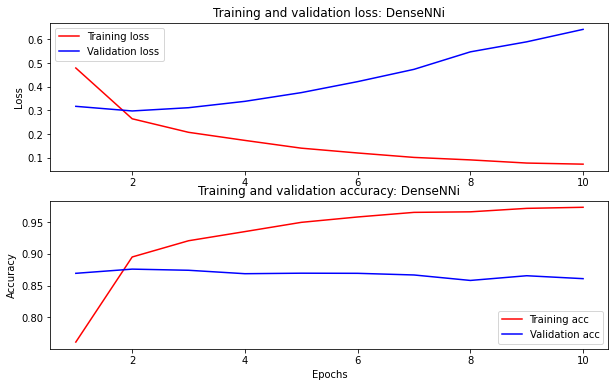

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: DenseNNi')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: DenseNNi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Conclusion

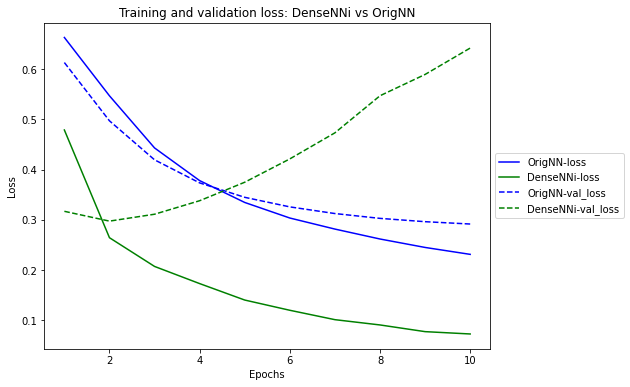

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(epochs, historyOrigNN.history['loss'], 'b',label='OrigNN-loss')
plt.plot(epochs, historyDenseNNi.history['loss'], 'g', label='DenseNNi-loss')
plt.plot(epochs, historyOrigNN.history['val_loss'], 'b',linestyle='--', label='OrigNN-val_loss')
plt.plot(epochs, historyDenseNNi.history['val_loss'], 'g', linestyle='--', label='DenseNNi-val_loss')
plt.title('Training and validation loss: DenseNNi vs OrigNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation loss:

The OrigNN loss and validation slightly decrease from around 0.6 to 0.25. After epoch 5 the validation loss is higher than the loss.

The DenseNNi loss dramatically decreases from around 0.5 to 0.25 at epoch 2, then slightly decreases till the end(loss < 0.1). After epoch 2 the validation loss increase in the opposite direction of the DenseNNi loss.

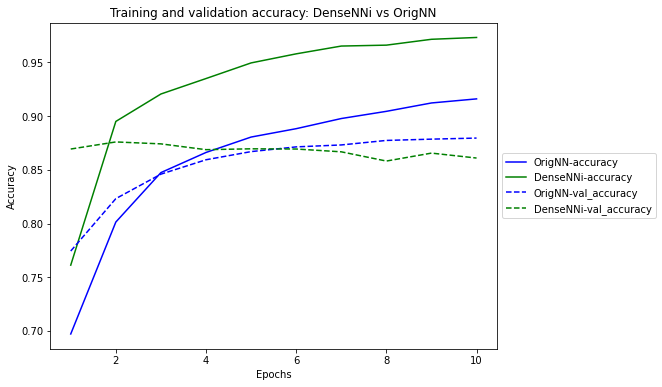

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(epochs, historyOrigNN.history['binary_accuracy'], 'b',label='OrigNN-accuracy')
plt.plot(epochs, historyDenseNNi.history['binary_accuracy'], 'g', label='DenseNNi-accuracy')
plt.plot(epochs, historyOrigNN.history['val_binary_accuracy'], 'b',linestyle='--', label='OrigNN-val_accuracy')
plt.plot(epochs, historyDenseNNi.history['val_binary_accuracy'], 'g', linestyle='--', label='DenseNNi-val_accuracy')
plt.title('Training and validation accuracy: DenseNNi vs OrigNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation accuracy: 

The accuracy and validation accuracy of OrigNN slightly increase from around 0.7 to 0.9 by 10 epochs. After epoch 3 the validation accuracy is lower than the accuracy.

The DenseNNi accuracy dramatically increases from around 0.75 to 0.9 with the first 2 epochs, then slightly increases till the end(accurary > 0.95).
The DenseNNi validation accuracy is around 0.87 from the first epoch and stays the same till the last epoch. This indicates overffting.

At the last epoch even though the accuracy of DenseNNi(0.9733) is greater than OrigNN(0.8796). However, the OrigNN is perform better as it does not overfit.

We can see the result from evaluate models with test set:

DenseNNi -> loss: 0.7916 - binary_accuracy: 0.8366

OrigNN -> loss: 0.3105 - binary_accuracy: 0.8730

Therefore, adding the dense(120) hidden layer to the OrigNN makes model overffit. 

## Task 2

Task 2 [1 marks]
In DenseNNi you should have two dropout layers, both with dropout hyperparameter 0.2.  In this task you're going to investigate the effect of changing the dropout hyperparameter.  Let D = 0.3 + 0.05 * N.  Investigate three new networks based on the new combinations of dropout hyperparameter, i.e.

1. first dropout layer has hyperparameter 0.2 and the second has hyperparameter D (call this model DenseNNii);
2. first dropout layer has hyperparameter D and the second has hyperparameter 0.2 (call this model DenseNNiii);
3. both dropout layers have hyperparameter D (call this model DenseNNiv).

In your notebook, compare the performance of all four variants of DenseNN with OrigNN, considering the performance at each epoch, not just the final one.  Which is the best?

### DenseNNii

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

DenseNNii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(D), #D=0.35
  layers.Dense(DHL), #DHL=120
  layers.Dense(1)])

DenseNNii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

DenseNNii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 120)               2040      
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                        

In [ ]:
epochs = 10
historyDenseNNii = DenseNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4916 - binary_accuracy: 0.7526 - val_loss: 0.3204 - val_binary_accuracy: 0.8676
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2760 - binary_accuracy: 0.8910 - val_loss: 0.2910 - val_binary_accuracy: 0.8780
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2207 - binary_accuracy: 0.9153 - val_loss: 0.3023 - val_binary_accuracy: 0.8788
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1886 - binary_accuracy: 0.9289 - val_loss: 0.3175 - val_binary_accuracy: 0.8764
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1564 - binary_accuracy: 0.9430 - val_loss: 0.3571 - val_binary_accuracy: 0.8698
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1372 - binary_accuracy: 0.9507 - val_loss: 0.3849 - val_binary_accuracy: 0.8706
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

In [ ]:
loss, accuracy = DenseNNii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.6822 - binary_accuracy: 0.8353
Loss:  0.6822458505630493
Accuracy:  0.835319995880127


In [ ]:
history_dict = historyDenseNNii.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

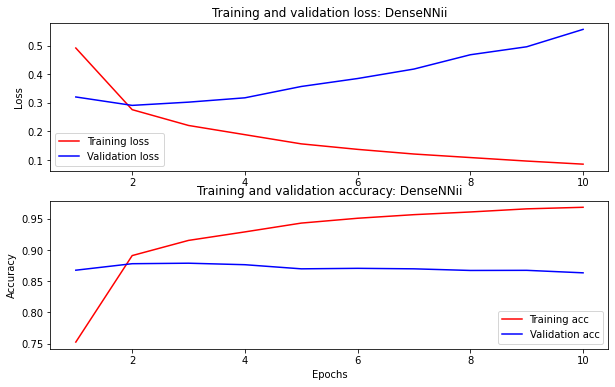

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: DenseNNii')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: DenseNNii')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### DenseNNiii

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

DenseNNiii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(D), #D=0.35
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(DHL), #DHL=120
  layers.Dense(1)])

DenseNNiii.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

DenseNNiii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 120)               2040      
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                        

In [ ]:
epochs = 10
historyDenseNNiii = DenseNNiii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4856 - binary_accuracy: 0.7563 - val_loss: 0.3223 - val_binary_accuracy: 0.8666
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2724 - binary_accuracy: 0.8910 - val_loss: 0.3016 - val_binary_accuracy: 0.8752
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2177 - binary_accuracy: 0.9153 - val_loss: 0.3070 - val_binary_accuracy: 0.8760
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1845 - binary_accuracy: 0.9312 - val_loss: 0.3288 - val_binary_accuracy: 0.8708
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1527 - binary_accuracy: 0.9439 - val_loss: 0.3593 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1350 - binary_accuracy: 0.9502 - val_loss: 0.3891 - val_binary_accuracy: 0.8704
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

In [ ]:
loss, accuracy = DenseNNiii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.6638 - binary_accuracy: 0.8372
Loss:  0.6637862324714661
Accuracy:  0.8371599912643433


In [ ]:
history_dict = historyDenseNNiii.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

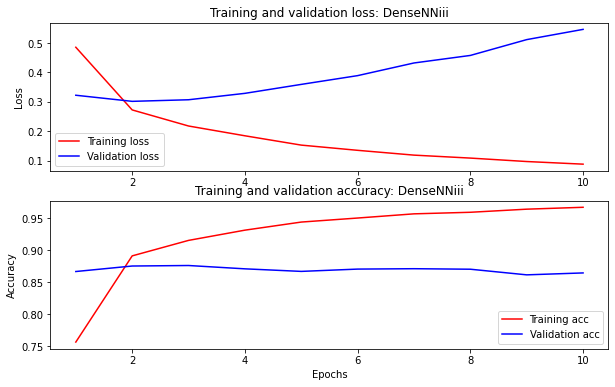

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: DenseNNiii')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: DenseNNiii')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### DenseNNiv

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

DenseNNiv = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(D), #D=0.35
  layers.GlobalAveragePooling1D(),
  layers.Dropout(D), #D=0.35
  layers.Dense(DHL), #DHL=120
  layers.Dense(1)])

DenseNNiv.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

DenseNNiv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 120)               2040      
                                                                 
 dense_1 (Dense)             (None, 1)                 121       
                                                        

In [ ]:
epochs = 10
historyDenseNNiv = DenseNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4993 - binary_accuracy: 0.7456 - val_loss: 0.3252 - val_binary_accuracy: 0.8656
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2848 - binary_accuracy: 0.8868 - val_loss: 0.2928 - val_binary_accuracy: 0.8776
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2324 - binary_accuracy: 0.9102 - val_loss: 0.2997 - val_binary_accuracy: 0.8788
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.2006 - binary_accuracy: 0.9231 - val_loss: 0.3112 - val_binary_accuracy: 0.8766
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1704 - binary_accuracy: 0.9374 - val_loss: 0.3427 - val_binary_accuracy: 0.8702
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1525 - binary_accuracy: 0.9427 - val_loss: 0.3581 - val_binary_accuracy: 0.8738
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [ ]:
loss, accuracy = DenseNNiv.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.5650 - binary_accuracy: 0.8418
Loss:  0.5650025010108948
Accuracy:  0.8417999744415283


In [ ]:
history_dict = historyDenseNNiv.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

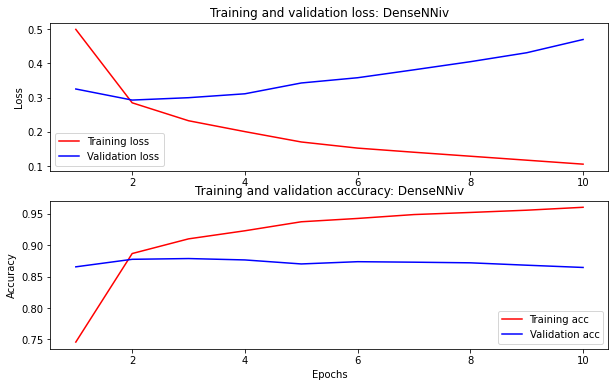

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: DenseNNiv')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: DenseNNiv')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Conclusion

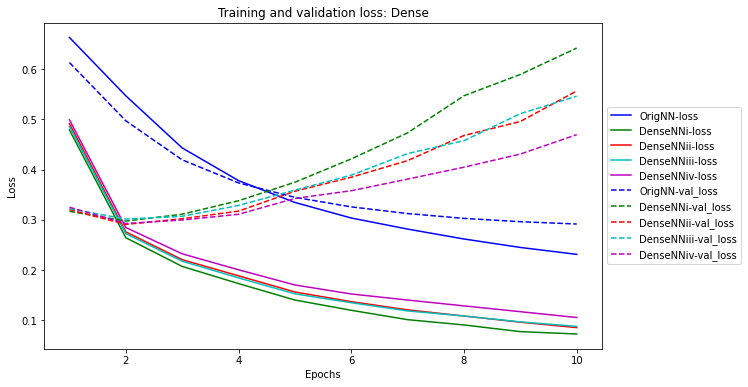

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, historyOrigNN.history['loss'], 'b',label='OrigNN-loss')
plt.plot(epochs, historyDenseNNi.history['loss'], 'g', label='DenseNNi-loss')
plt.plot(epochs, historyDenseNNii.history['loss'], 'r', label='DenseNNii-loss')
plt.plot(epochs, historyDenseNNiii.history['loss'], 'c', label='DenseNNiii-loss')
plt.plot(epochs, historyDenseNNiv.history['loss'], 'm', label='DenseNNiv-loss')
plt.plot(epochs, historyOrigNN.history['val_loss'], 'b',linestyle='--', label='OrigNN-val_loss')
plt.plot(epochs, historyDenseNNi.history['val_loss'], 'g', linestyle='--', label='DenseNNi-val_loss')
plt.plot(epochs, historyDenseNNii.history['val_loss'], 'r', linestyle='--', label='DenseNNii-val_loss')
plt.plot(epochs, historyDenseNNiii.history['val_loss'], 'c', linestyle='--', label='DenseNNiii-val_loss')
plt.plot(epochs, historyDenseNNiv.history['val_loss'], 'm', linestyle='--', label='DenseNNiv-val_loss')
plt.title('Training and validation loss: Dense')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation loss:

The OrigNN loss and validation slightly decrease from around 0.6 to 0.25. After epoch 5 the validation loss is higher than the loss.

The DenseNNi, DenseNNii, DenseNNiii and DenseNNiv losses dramatically decrease from around 0.5 to around 0.25 at epoch 2, then slightly decrease till the end(loss between 0.15 - 0.1). 

After epoch 2 the validation losses of DenseNNi, DenseNNii, DenseNNiii and DenseNNiv increase in the opposite direction of the DenseNNi loss. The worst is DenseNNi which has a difference between the loss and the validation loss of more than 0.5.

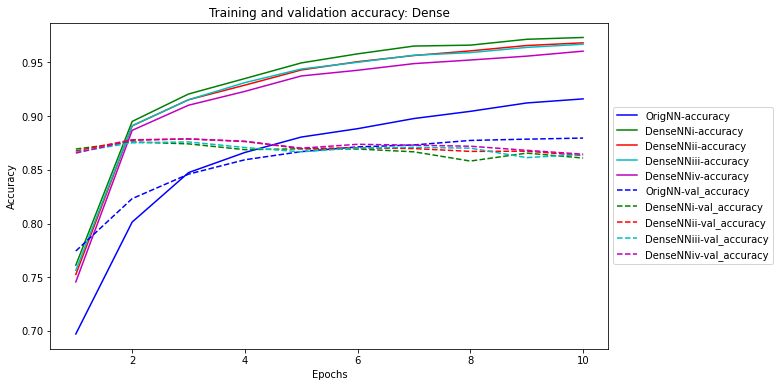

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, historyOrigNN.history['binary_accuracy'], 'b',label='OrigNN-accuracy')
plt.plot(epochs, historyDenseNNi.history['binary_accuracy'], 'g', label='DenseNNi-accuracy')
plt.plot(epochs, historyDenseNNii.history['binary_accuracy'], 'r', label='DenseNNii-accuracy')
plt.plot(epochs, historyDenseNNiii.history['binary_accuracy'], 'c', label='DenseNNiii-accuracy')
plt.plot(epochs, historyDenseNNiv.history['binary_accuracy'], 'm', label='DenseNNiv-accuracy')
plt.plot(epochs, historyOrigNN.history['val_binary_accuracy'], 'b',linestyle='--', label='OrigNN-val_accuracy')
plt.plot(epochs, historyDenseNNi.history['val_binary_accuracy'], 'g', linestyle='--', label='DenseNNi-val_accuracy')
plt.plot(epochs, historyDenseNNii.history['val_binary_accuracy'], 'r', linestyle='--', label='DenseNNii-val_accuracy')
plt.plot(epochs, historyDenseNNiii.history['val_binary_accuracy'], 'c', linestyle='--', label='DenseNNiii-val_accuracy')
plt.plot(epochs, historyDenseNNiv.history['val_binary_accuracy'], 'm', linestyle='--', label='DenseNNiv-val_accuracy')
plt.title('Training and validation accuracy: Dense')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation accuracy: 

The accuracy and validation accuracy of OrigNN slightly increase from around 0.7 to 0.9 by 10 epochs. After epoch 3 the validation accuracy is lower than the accuracy.

The DenseNNi, DenseNNii, DenseNNiii and DenseNNiv accuracy dramatically increases from around 0.75 to 0.9 with the first 2 epochs, then slightly increase till the end(accuracy around 0.95).
The DenseNNi, DenseNNii, DenseNNiii and DenseNNiv validation accuracy are around 0.87 from the first epoch and stays the same till the last epoch. This indicates overfitting.



At the last epoch even though the accuracy of all DenseNN(x) models(~0.95) is greater than OrigNN(0.8796). However, the OrigNN performs better as it does not overfit.

We can see the better result of OrigNN by evaluating models on the test set:

DenseNNi -> loss: 0.7916 - binary_accuracy: 0.8366

DenseNNii -> loss: 0.6822 - binary_accuracy: 0.8353

DenseNNiii -> loss: 0.6638 - binary_accuracy: 0.8372

DenseNNiv -> loss: 0.5650 - binary_accuracy: 0.8418

OrigNN -> loss: 0.3105 - binary_accuracy: 0.8730

Comparing within DenseNN(x) models the best model is DenseNNii

And the best model is OrigNN.

## Task 3


Use a CNN architecture rather than the dense network in the tutorial, with one Conv1D layer and one pooling layer, with kernel size K = (N div 2) + 5 (where div represents integer division), as in https://keras.io/examples/nlp/text_classification_from_scratch/.  

Use the final dense and dropout layer as they do too.  
As your network should (as in both examples) have a dropout layer immediately after the embedding layer, 
your network should consequently have two dropout layers; 
apply the same four combinations of dropout hyperparameters (selecting from 0.2, D) as in the previous tasks.  

Call these four network variants CNNi, CNNii, CNNiii and CNNiv.  In your notebook, compare the performance of these, considering the performance at each epoch, not just the final one.  

Then choose the best of these four, and call it CNN.  In your notebook, compare the performance of CNN with the best of your previous networks (OrigNN, DenseNN), considering the performance at each epoch, not just the final one. 

In [ ]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

### CNNi

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

CNNi = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(128, K, padding="valid", activation="relu", strides=3), #K=5
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid", name="predictions")])

CNNi.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

CNNi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                        

In [ ]:
epochs = 10
historyCNNi = CNNi.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 5ms/step - loss: 0.4093 - accuracy: 0.8100 - val_loss: 0.3099 - val_accuracy: 0.8742
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2208 - accuracy: 0.9165 - val_loss: 0.3000 - val_accuracy: 0.8778
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1479 - accuracy: 0.9452 - val_loss: 0.3294 - val_accuracy: 0.8750
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0944 - accuracy: 0.9679 - val_loss: 0.3830 - val_accuracy: 0.8722
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0574 - accuracy: 0.9816 - val_loss: 0.4610 - val_accuracy: 0.8634
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0381 - accuracy: 0.9884 - val_loss: 0.4941 - val_accuracy: 0.8674
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0215 - accuracy: 0.9946 - val_loss: 0.5716 - val_accuracy: 0.8644
Epoch

In [ ]:
loss, accuracy = CNNi.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.8856 - accuracy: 0.8443
Loss:  0.8856391906738281
Accuracy:  0.8442800045013428


In [ ]:
history_dict = historyCNNi.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

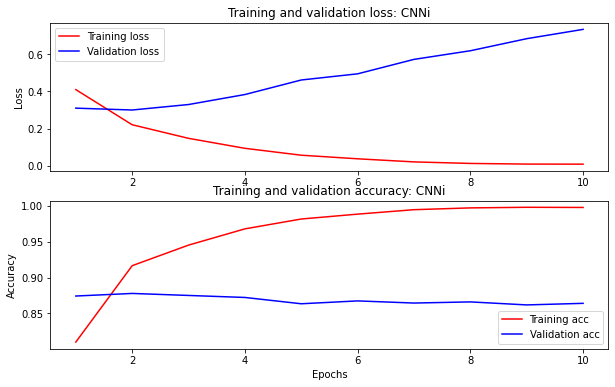

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: CNNi')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: CNNi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### CNNii

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

CNNii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Conv1D(128, K, padding="valid", activation="relu", strides=3), #K=5
  layers.GlobalAveragePooling1D(),
  layers.Dropout(D), #D=0.35
  layers.Dense(1, activation="sigmoid", name="predictions")])

CNNii.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

CNNii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                        

In [ ]:
epochs = 10
historyCNNii = CNNii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.4172 - accuracy: 0.8045 - val_loss: 0.3092 - val_accuracy: 0.8740
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2304 - accuracy: 0.9111 - val_loss: 0.2937 - val_accuracy: 0.8806
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1598 - accuracy: 0.9399 - val_loss: 0.3184 - val_accuracy: 0.8756
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1090 - accuracy: 0.9624 - val_loss: 0.3641 - val_accuracy: 0.8746
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0656 - accuracy: 0.9801 - val_loss: 0.4452 - val_accuracy: 0.8652
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0443 - accuracy: 0.9866 - val_loss: 0.4904 - val_accuracy: 0.8682
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0273 - accuracy: 0.9930 - val_loss: 0.5548 - val_accuracy: 0.8656
Epoch 

In [ ]:
loss, accuracy = CNNii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.8742 - accuracy: 0.8350
Loss:  0.8741795420646667
Accuracy:  0.8350399732589722


In [ ]:
history_dict = historyCNNii.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

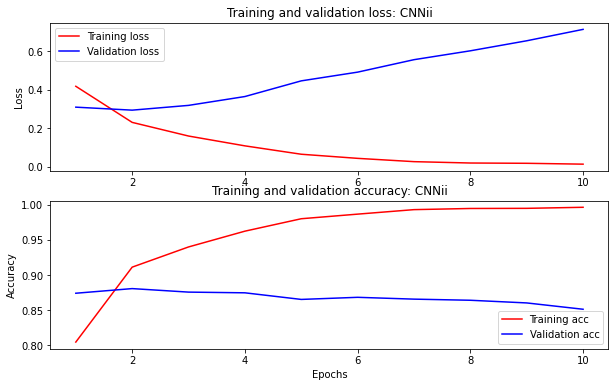

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: CNNii')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: CNNii')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### CNNiii

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

CNNiii = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(D), #D=0.35
  layers.Conv1D(128, K, padding="valid", activation="relu", strides=3), #K=5
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid", name="predictions")])

CNNiii.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

CNNiii.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                        

In [ ]:
epochs = 10
historyCNNiii = CNNiii.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4146 - accuracy: 0.8041 - val_loss: 0.3106 - val_accuracy: 0.8738
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2263 - accuracy: 0.9139 - val_loss: 0.2957 - val_accuracy: 0.8798
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1560 - accuracy: 0.9419 - val_loss: 0.3239 - val_accuracy: 0.8780
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1041 - accuracy: 0.9644 - val_loss: 0.3690 - val_accuracy: 0.8722
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0665 - accuracy: 0.9775 - val_loss: 0.4313 - val_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0452 - accuracy: 0.9857 - val_loss: 0.4797 - val_accuracy: 0.8672
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0299 - accuracy: 0.9913 - val_loss: 0.5419 - val_accuracy: 0.8656
Epoch 

In [ ]:
loss, accuracy = CNNiii.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.9142 - accuracy: 0.8343
Loss:  0.9142255187034607
Accuracy:  0.8342800140380859


In [ ]:
history_dict = historyCNNiii.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

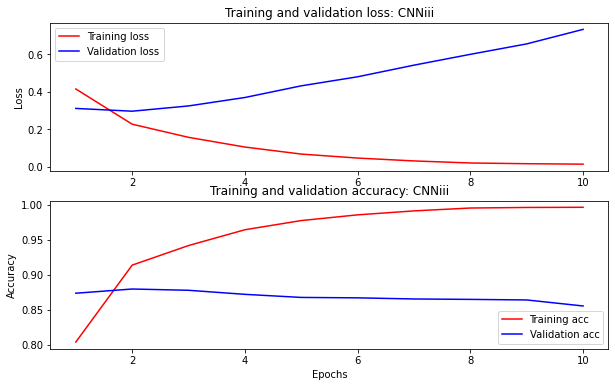

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: CNNiii')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: CNNiii')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


### CNNiv

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

CNNiv = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(D), #D=0.35
  layers.Conv1D(128, K, padding="valid", activation="relu", strides=3), #K=5
  layers.GlobalAveragePooling1D(),
  layers.Dropout(D), #D=0.35
  layers.Dense(1, activation="sigmoid", name="predictions")])

CNNiv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

CNNiv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560128   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                        

In [ ]:
epochs = 10
historyCNNiv = CNNiv.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4231 - accuracy: 0.7997 - val_loss: 0.3084 - val_accuracy: 0.8740
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2355 - accuracy: 0.9089 - val_loss: 0.2893 - val_accuracy: 0.8804
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1665 - accuracy: 0.9369 - val_loss: 0.3133 - val_accuracy: 0.8770
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1185 - accuracy: 0.9575 - val_loss: 0.3521 - val_accuracy: 0.8738
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0737 - accuracy: 0.9754 - val_loss: 0.4168 - val_accuracy: 0.8686
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0509 - accuracy: 0.9846 - val_loss: 0.4784 - val_accuracy: 0.8668
Epoch 7/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0345 - accuracy: 0.9905 - val_loss: 0.5537 - val_accuracy: 0.8616
Epoch 

In [ ]:
loss, accuracy = CNNiv.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.8918 - accuracy: 0.8286
Loss:  0.8918370604515076
Accuracy:  0.8286399841308594


In [ ]:
history_dict = historyCNNiv.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

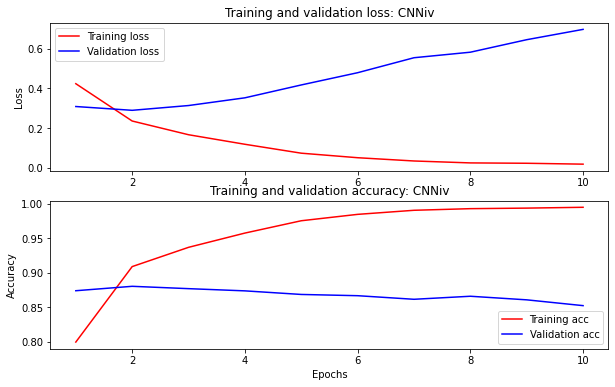

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: CNNiv')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: CNNiv')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Conclusion

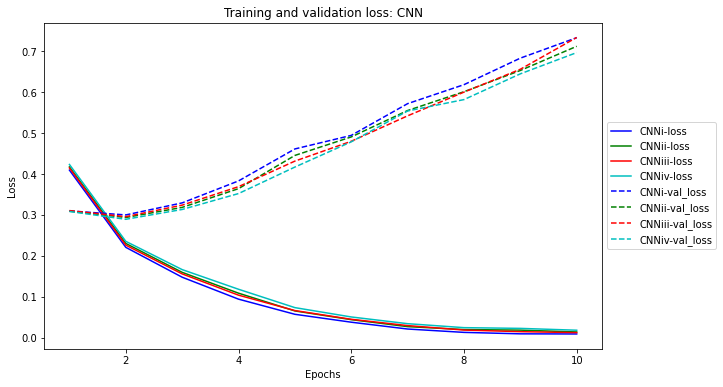

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, historyCNNi.history['loss'], 'b',label='CNNi-loss')
plt.plot(epochs, historyCNNii.history['loss'], 'g', label='CNNii-loss')
plt.plot(epochs, historyCNNiii.history['loss'], 'r', label='CNNiii-loss')
plt.plot(epochs, historyCNNiv.history['loss'], 'c', label='CNNiv-loss')
plt.plot(epochs, historyCNNi.history['val_loss'], 'b',linestyle='--', label='CNNi-val_loss')
plt.plot(epochs, historyCNNii.history['val_loss'], 'g', linestyle='--', label='CNNii-val_loss')
plt.plot(epochs, historyCNNiii.history['val_loss'], 'r', linestyle='--', label='CNNiii-val_loss')
plt.plot(epochs, historyCNNiv.history['val_loss'], 'c', linestyle='--', label='CNNiv-val_loss')
plt.title('Training and validation loss: CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation loss:

The CNNi, CNNii, CNNiii and CNNiv losses dramatically decrease from around 0.4 to around 0.23 at epoch 2, then slightly decrease till epoch 10 (loss ~0.01).

At epoch 2 all the validation losses a little bit decrease from ~0.31 to ~0.29 After that, the validation losses of CNNi, CNNii, CNNiii and CNNiv increase in the opposite direction of the losses. At epoch 10 all the validation losses are approximately 0.7

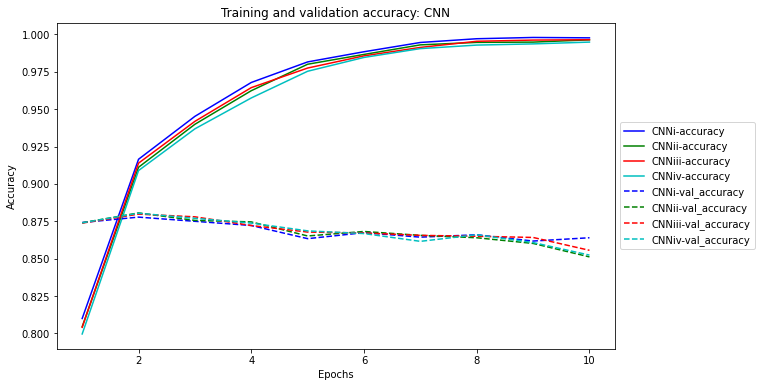

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, historyCNNi.history['accuracy'], 'b',label='CNNi-accuracy')
plt.plot(epochs, historyCNNii.history['accuracy'], 'g', label='CNNii-accuracy')
plt.plot(epochs, historyCNNiii.history['accuracy'], 'r', label='CNNiii-accuracy')
plt.plot(epochs, historyCNNiv.history['accuracy'], 'c', label='CNNiv-accuracy')
plt.plot(epochs, historyCNNi.history['val_accuracy'], 'b',linestyle='--', label='CNNi-val_accuracy')
plt.plot(epochs, historyCNNii.history['val_accuracy'], 'g', linestyle='--', label='CNNii-val_accuracy')
plt.plot(epochs, historyCNNiii.history['val_accuracy'], 'r', linestyle='--', label='CNNiii-val_accuracy')
plt.plot(epochs, historyCNNiv.history['val_accuracy'], 'c', linestyle='--', label='CNNiv-val_accuracy')
plt.title('Training and validation accuracy: CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Training and validation accuracy: 

The CNNi, CNNii, CNNiii and CNNiv accuracy dramatically increases from around 0.8 to almost 0.925 within the first 2 epochs, then slightly increase till the end(accuracy around 0.99).
The CNNi, CNNii, CNNiii and CNNiv validation accuracy are around 0.875 from the first epoch and slightly decrease to 0.865 at the last epoch. It is around a 10% difference in accuracy and validation accuracy, this can be considered as overfitting

We can see the performance of CNN(x) by evaluating models on the test set:

CNNi -> loss: 0.8856 - accuracy: 0.8443

CNNii -> loss: 0.8742 - accuracy: 0.8350

CNNiii -> loss: 0.9142 - accuracy: 0.8343

CNNiv -> loss: 0.8918 - accuracy: 0.8286

Consider all performance on train, validation and test dataset, the best model is CNNi (layers.Dropout(0.2) and layers.Dropout(0.2))

#### Comparing between OrigNN, DenseNN and CNN

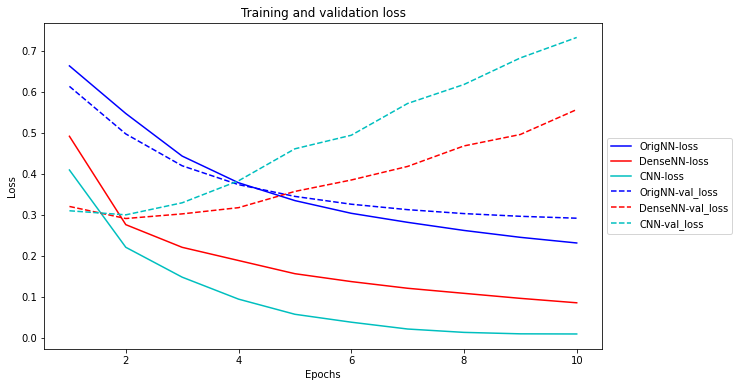

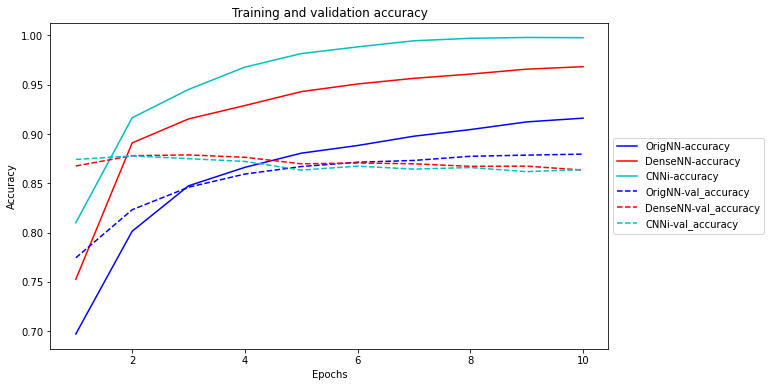

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, historyOrigNN.history['loss'], 'b',label='OrigNN-loss')
plt.plot(epochs, historyDenseNNii.history['loss'], 'r', label='DenseNN-loss')
plt.plot(epochs, historyCNNi.history['loss'], 'c', label='CNN-loss')
plt.plot(epochs, historyOrigNN.history['val_loss'], 'b', linestyle='--', label='OrigNN-val_loss')
plt.plot(epochs, historyDenseNNii.history['val_loss'], 'r', linestyle='--',  label='DenseNN-val_loss')
plt.plot(epochs, historyCNNi.history['val_loss'], 'c', linestyle='--', label='CNN-val_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(10,6))
plt.plot(epochs, historyOrigNN.history['binary_accuracy'], 'b',label='OrigNN-accuracy')
plt.plot(epochs, historyDenseNNii.history['binary_accuracy'], 'r', label='DenseNN-accuracy')
plt.plot(epochs, historyCNNi.history['accuracy'], 'c', label='CNNi-accuracy')
plt.plot(epochs, historyOrigNN.history['val_binary_accuracy'], 'b',linestyle='--', label='OrigNN-val_accuracy')
plt.plot(epochs, historyDenseNNii.history['val_binary_accuracy'], 'r', linestyle='--', label='DenseNN-val_accuracy')
plt.plot(epochs, historyCNNi.history['val_accuracy'], 'c', linestyle='--', label='CNNi-val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We can see that CNN has the most difference between train and validation performances; ~15% difference between accuracy and validation accuracy, ~60% difference between loss and validation loss. Followed by DenseNN; ~10% difference between accuracy and validation accuracy, ~40% difference between loss and validation loss. Therefore, the best model is OrigNN the difference between train and validation performances is just around 5%

## Task 4


Choose the best of your previous architectures: call this NNBest.  Train the model on subsets of the original training data, of sizes (20%, 40%, 60%, 80%, 100%).  You should keep the validation set the same size for all training set sizes.  Plot the accuracies of the model for each of those training set sizes.  

In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)
print("train set size: ", len(train_ds))
print("test set size: ", len(val_ds))
print("validate test set size: ", len(test_ds))

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
train set size:  625
test set size:  157
validate test set size:  782


In [ ]:
train_ds.cardinality().numpy()

625

In [ ]:
len(train_ds)

625

In [ ]:
train_20 = train_ds.take(train_ds.cardinality().numpy()*0.2) 
train_40 = train_ds.take(train_ds.cardinality().numpy()*0.4) 
train_60 = train_ds.take(train_ds.cardinality().numpy()*0.6) 
train_80 = train_ds.take(train_ds.cardinality().numpy()*0.8) 

In [ ]:
print(train_20)
print(train_40)
print(train_60)
print(train_80)
print("train 20% size: ", len(train_20))
print("train 40% size: ", len(train_40))
print("train 60% size: ", len(train_60))
print("train 80% size: ", len(train_80))
print("train 100% size: ", len(train_ds))

<TakeDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
train 20% size:  125
train 40% size:  250
train 60% size:  375
train 80% size:  500
train 100% size:  625


## NNBest

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

NNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### 20% of the original training data

In [ ]:
epochs = 10
history20 = NNBest.fit(
    train_20,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
125/125 [==============================] - 2s 8ms/step - loss: 0.6908 - binary_accuracy: 0.5375 - val_loss: 0.6877 - val_binary_accuracy: 0.6842
Epoch 2/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6814 - binary_accuracy: 0.6855 - val_loss: 0.6765 - val_binary_accuracy: 0.7376
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6638 - binary_accuracy: 0.7552 - val_loss: 0.6584 - val_binary_accuracy: 0.7464
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6384 - binary_accuracy: 0.7825 - val_loss: 0.6354 - val_binary_accuracy: 0.7532
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.6087 - binary_accuracy: 0.7977 - val_loss: 0.6102 - val_binary_accuracy: 0.7656
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.5767 - binary_accuracy: 0.8100 - val_loss: 0.5847 - val_binary_accuracy: 0.7812
Epoch 7/10
125/125 [==============================] - 1s 7ms/ste

In [ ]:
loss, accuracy = NNBest.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.5013 - binary_accuracy: 0.8080
Loss:  0.501311182975769
Accuracy:  0.8080000281333923


In [ ]:
history_dict = history20.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

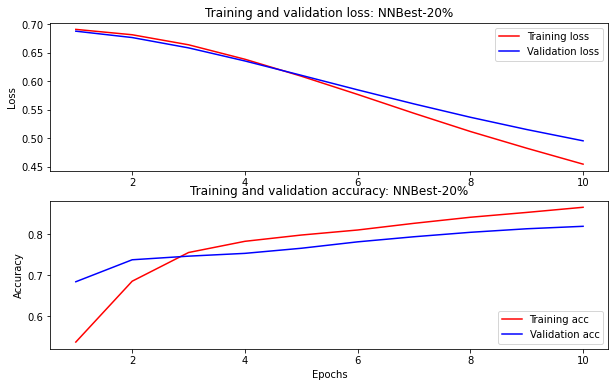

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: NNBest-20%')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: NNBest-20%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 40% of the original training data

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

NNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [ ]:
epochs = 10
history40 = NNBest.fit(
    train_40,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
250/250 [==============================] - 2s 6ms/step - loss: 0.6870 - binary_accuracy: 0.6143 - val_loss: 0.6770 - val_binary_accuracy: 0.7258
Epoch 2/10
250/250 [==============================] - 1s 5ms/step - loss: 0.6566 - binary_accuracy: 0.7519 - val_loss: 0.6375 - val_binary_accuracy: 0.7744
Epoch 3/10
250/250 [==============================] - 1s 5ms/step - loss: 0.6049 - binary_accuracy: 0.7871 - val_loss: 0.5872 - val_binary_accuracy: 0.7940
Epoch 4/10
250/250 [==============================] - 1s 5ms/step - loss: 0.5482 - binary_accuracy: 0.8125 - val_loss: 0.5388 - val_binary_accuracy: 0.8082
Epoch 5/10
250/250 [==============================] - 1s 5ms/step - loss: 0.4956 - binary_accuracy: 0.8361 - val_loss: 0.4963 - val_binary_accuracy: 0.8250
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.4492 - binary_accuracy: 0.8551 - val_loss: 0.4609 - val_binary_accuracy: 0.8346
Epoch 7/10
250/250 [==============================] - 1s 6ms/ste

In [ ]:
loss, accuracy = NNBest.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3874 - binary_accuracy: 0.8497
Loss:  0.38744932413101196
Accuracy:  0.8497200012207031


In [ ]:
history_dict = history40.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

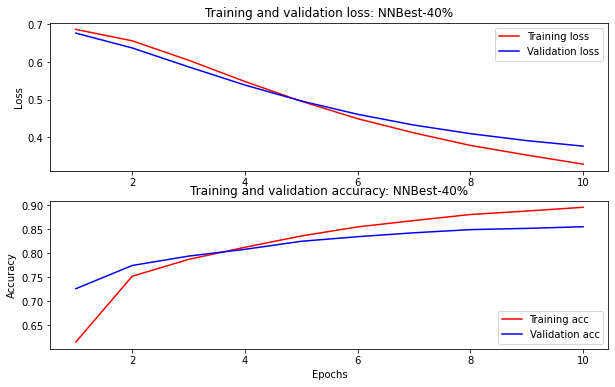

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: NNBest-40%')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: NNBest-40%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 60% of the original training data

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

NNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [ ]:
epochs = 10
history60 = NNBest.fit(
    train_60,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
375/375 [==============================] - 3s 6ms/step - loss: 0.6812 - binary_accuracy: 0.6491 - val_loss: 0.6605 - val_binary_accuracy: 0.7566
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.6221 - binary_accuracy: 0.7702 - val_loss: 0.5877 - val_binary_accuracy: 0.7924
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5424 - binary_accuracy: 0.8112 - val_loss: 0.5167 - val_binary_accuracy: 0.8228
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.4725 - binary_accuracy: 0.8421 - val_loss: 0.4602 - val_binary_accuracy: 0.8376
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.4171 - binary_accuracy: 0.8602 - val_loss: 0.4189 - val_binary_accuracy: 0.8476
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3757 - binary_accuracy: 0.8748 - val_loss: 0.3887 - val_binary_accuracy: 0.8530
Epoch 7/10
375/375 [==============================] - 2s 5ms/ste

In [ ]:
loss, accuracy = NNBest.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3430 - binary_accuracy: 0.8623
Loss:  0.34297674894332886
Accuracy:  0.862280011177063


In [ ]:
history_dict = history60.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

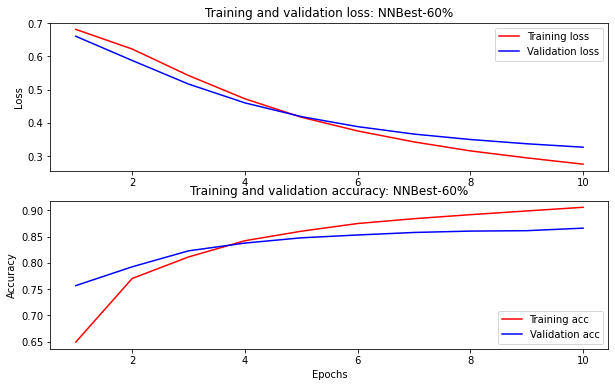

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: NNBest-60%')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: NNBest-60%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 80% of the original training data

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

NNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [ ]:
epochs = 10
history80 = NNBest.fit(
    train_80,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
500/500 [==============================] - 3s 5ms/step - loss: 0.6727 - binary_accuracy: 0.6787 - val_loss: 0.6377 - val_binary_accuracy: 0.7664
Epoch 2/10
500/500 [==============================] - 3s 5ms/step - loss: 0.5824 - binary_accuracy: 0.7869 - val_loss: 0.5396 - val_binary_accuracy: 0.8084
Epoch 3/10
500/500 [==============================] - 2s 5ms/step - loss: 0.4857 - binary_accuracy: 0.8320 - val_loss: 0.4613 - val_binary_accuracy: 0.8372
Epoch 4/10
500/500 [==============================] - 3s 5ms/step - loss: 0.4145 - binary_accuracy: 0.8582 - val_loss: 0.4086 - val_binary_accuracy: 0.8492
Epoch 5/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3649 - binary_accuracy: 0.8727 - val_loss: 0.3741 - val_binary_accuracy: 0.8570
Epoch 6/10
500/500 [==============================] - 2s 5ms/step - loss: 0.3292 - binary_accuracy: 0.8849 - val_loss: 0.3503 - val_binary_accuracy: 0.8620
Epoch 7/10
500/500 [==============================] - 2s 5ms/ste

In [ ]:
loss, accuracy = NNBest.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3212 - binary_accuracy: 0.8710
Loss:  0.3212474286556244
Accuracy:  0.8709999918937683


In [ ]:
history_dict = history80.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

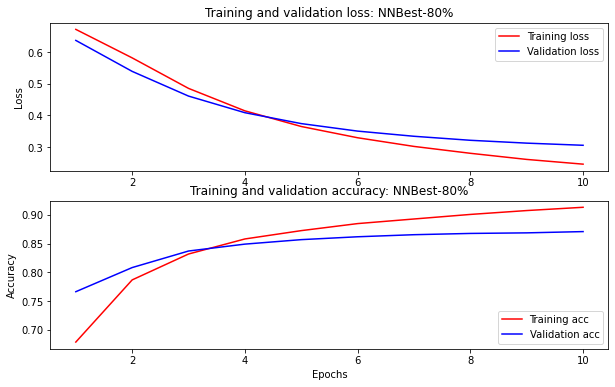

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: NNBest-80%')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: NNBest-80%')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### 100% of the original training data

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

NNBest = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

NNBest.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

NNBest.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [24]:
epochs = 10
history100 = NNBest.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 8s 7ms/step - loss: 0.6633 - binary_accuracy: 0.6971 - val_loss: 0.6133 - val_binary_accuracy: 0.7744
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5471 - binary_accuracy: 0.8014 - val_loss: 0.4973 - val_binary_accuracy: 0.8232
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4433 - binary_accuracy: 0.8475 - val_loss: 0.4196 - val_binary_accuracy: 0.8460
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3782 - binary_accuracy: 0.8662 - val_loss: 0.3737 - val_binary_accuracy: 0.8594
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3347 - binary_accuracy: 0.8806 - val_loss: 0.3450 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3037 - binary_accuracy: 0.8884 - val_loss: 0.3259 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [25]:
loss, accuracy = NNBest.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3105 - binary_accuracy: 0.8730
Loss:  0.3105050325393677
Accuracy:  0.8730000257492065


In [26]:
history_dict = history100.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

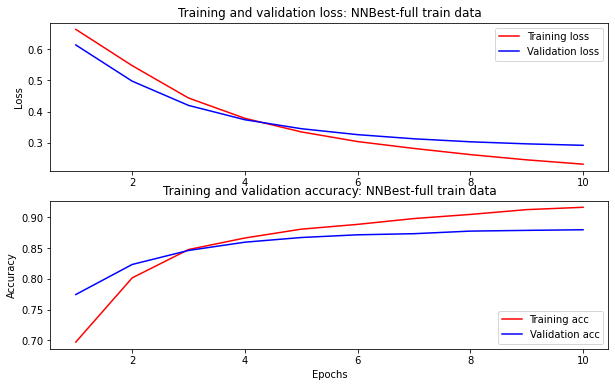

In [47]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: NNBest-full train data')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: NNBest-full train data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


### Conclusion

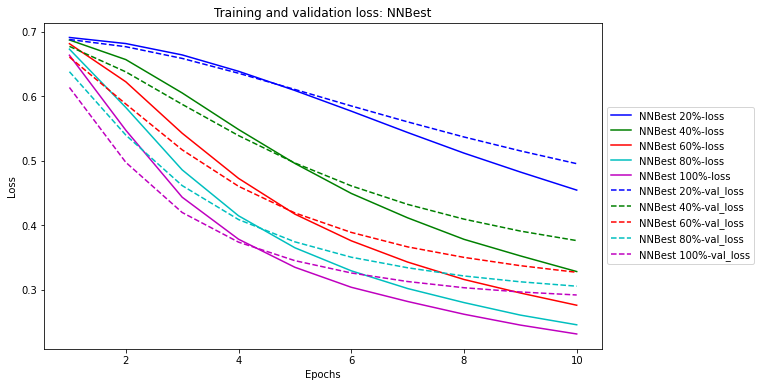

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, history20.history['loss'], 'b',label='NNBest 20%-loss')
plt.plot(epochs, history40.history['loss'], 'g', label='NNBest 40%-loss')
plt.plot(epochs, history60.history['loss'], 'r', label='NNBest 60%-loss')
plt.plot(epochs, history80.history['loss'], 'c', label='NNBest 80%-loss')
plt.plot(epochs, history100.history['loss'], 'm', label='NNBest 100%-loss')
plt.plot(epochs, history20.history['val_loss'], 'b',linestyle='--', label='NNBest 20%-val_loss')
plt.plot(epochs, history40.history['val_loss'], 'g', linestyle='--', label='NNBest 40%-val_loss')
plt.plot(epochs, history60.history['val_loss'], 'r', linestyle='--', label='NNBest 60%-val_loss')
plt.plot(epochs, history80.history['val_loss'], 'c', linestyle='--', label='NNBest 80%-val_loss')
plt.plot(epochs, history100.history['val_loss'], 'm', linestyle='--', label='NNBest 100%-val_loss')
plt.title('Training and validation loss: NNBest')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation loss:

Increasing the number of training dataset can reduce the loss of the model.

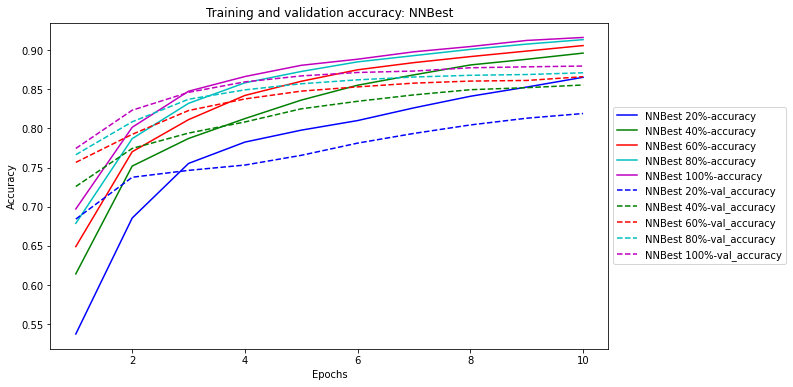

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(epochs, history20.history['binary_accuracy'], 'b', label='NNBest 20%-accuracy')
plt.plot(epochs, history40.history['binary_accuracy'], 'g', label='NNBest 40%-accuracy')
plt.plot(epochs, history60.history['binary_accuracy'], 'r',label='NNBest 60%-accuracy')
plt.plot(epochs, history80.history['binary_accuracy'], 'c',label='NNBest 80%-accuracy')
plt.plot(epochs, history100.history['binary_accuracy'], 'm', label='NNBest 100%-accuracy')
plt.plot(epochs, history20.history['val_binary_accuracy'], 'b',linestyle='--', label='NNBest 20%-val_accuracy')
plt.plot(epochs, history40.history['val_binary_accuracy'], 'g', linestyle='--', label='NNBest 40%-val_accuracy')
plt.plot(epochs, history60.history['val_binary_accuracy'], 'r', linestyle='--', label='NNBest 60%-val_accuracy')
plt.plot(epochs, history80.history['val_binary_accuracy'], 'c', linestyle='--', label='NNBest 80%-val_accuracy')
plt.plot(epochs, history100.history['val_binary_accuracy'], 'm', linestyle='--', label='NNBest 100%-val_accuracy')
plt.title('Training and validation accuracy: NNBest')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#place legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Training and validation accuracy:

We can see that increasing the number of training dataset can increase the accuracy of the model. 


Therefore, increasing the number of training dataset can improve the model performances.

## Task 6.1

[Harder question] Change your NNBest model to apply dropout at test time, as described in the lecture notes on Training Deep Neural Networks.  Call this NNBestDrop.  Does this change the overall accuracy of the model?  



### NNBestDrop

In [55]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [56]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

NNBestDrop = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, tf.keras.layers.Dropout) else layer
    for layer in NNBest.layers
])

NNBestDrop.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

NNBestDrop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 mc_dropout (MCDropout)      (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 mc_dropout_1 (MCDropout)    (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [57]:
NNBestDrop.set_weights(NNBest.get_weights())

In [58]:
epochs = 10
historyNNBestDrop= NNBestDrop.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1666 - binary_accuracy: 0.9433 - val_loss: 0.2937 - val_binary_accuracy: 0.8814
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1583 - binary_accuracy: 0.9457 - val_loss: 0.2945 - val_binary_accuracy: 0.8818
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1502 - binary_accuracy: 0.9499 - val_loss: 0.2988 - val_binary_accuracy: 0.8840
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1447 - binary_accuracy: 0.9517 - val_loss: 0.3011 - val_binary_accuracy: 0.8822
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1364 - binary_accuracy: 0.9557 - val_loss: 0.3035 - val_binary_accuracy: 0.8816
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1304 - binary_accuracy: 0.9582 - val_loss: 0.3088 - val_binary_accuracy: 0.8806
Epoch 7/10
625/625 [==============================] - 2s 3ms/ste

In [59]:
loss, accuracy = NNBestDrop.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3773 - binary_accuracy: 0.8615
Loss:  0.37727081775665283
Accuracy:  0.861519992351532


In [60]:
history_dict = historyNNBestDrop.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

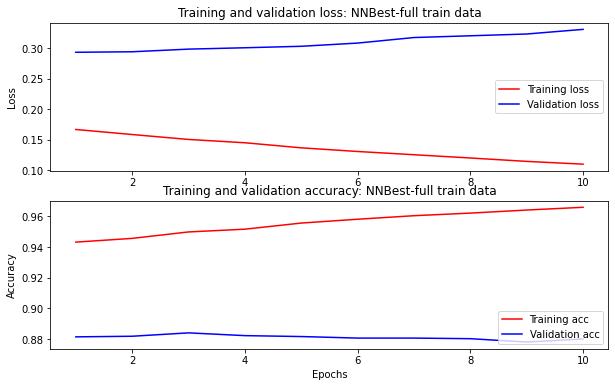

In [61]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss: NNBest-full train data')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy: NNBest-full train data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

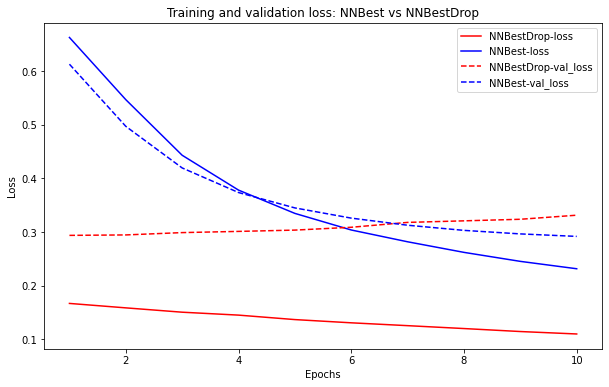

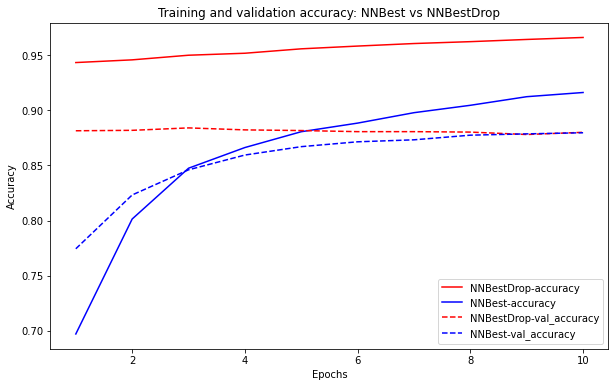

In [62]:
plt.figure(figsize=(10,6))
plt.plot(epochs, historyNNBestDrop.history['loss'], 'r',label='NNBestDrop-loss')
plt.plot(epochs, history100.history['loss'], 'b', label='NNBest-loss')
plt.plot(epochs, historyNNBestDrop.history['val_loss'], 'r',linestyle='--', label='NNBestDrop-val_loss')
plt.plot(epochs, history100.history['val_loss'], 'b', linestyle='--', label='NNBest-val_loss')
plt.title('Training and validation loss: NNBest vs NNBestDrop')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#place legend outside of plot
plt.legend()

plt.figure(figsize=(10,6))
plt.plot(epochs, historyNNBestDrop.history['binary_accuracy'], 'r', label='NNBestDrop-accuracy')
plt.plot(epochs, history100.history['binary_accuracy'], 'b', label='NNBest-accuracy')
plt.plot(epochs, historyNNBestDrop.history['val_binary_accuracy'], 'r',linestyle='--', label='NNBestDrop-val_accuracy')
plt.plot(epochs, history100.history['val_binary_accuracy'], 'b', linestyle='--', label='NNBest-val_accuracy')
plt.title('Training and validation accuracy: NNBest vs NNBestDrop')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

 Does this change the overall accuracy of the model?

The valid accuracy remains the same but training score keeps increasing till very high(0.96)

Select 5 examples of positive reviews and 5 examples of negative reviews from the test set, and discuss whether the probabilities assigned by NNBest or those assigned by NNBestDrop better reflect whether the review sentiment is clear (either positive or negative) or ambiguous.  (You may select the reviews however you wish: random, earliest in the test set, or whatever.)

In [159]:
negative5_texts = []
negative5_labels = []
positive5_texts = []
positive5_labels = []
for text_batch, label_batch in raw_test_ds.take(1): # Takes 1 batch
  for i in range(10):
    if label_batch.numpy()[i] == 0:
      negative5_texts.append(text_batch.numpy()[i])
      negative5_labels.append(label_batch.numpy()[i])
    else:  
      positive5_texts.append(text_batch.numpy()[i])
      positive5_labels.append(label_batch.numpy()[i])
print("Positive Reviews", negative5_texts)
print("Positive Labels", negative5_labels)
print("Positive Reviews", positive5_texts)
print("Positive Labels", positive5_labels)

Positive Reviews [b'***Possible spoilers***<br /><br />I\'ve read up on Dahmer a little and saw the new Dahmer film (with the same name) at an earlier time. This movie here concentrates rather much on the victims and killings, too little on Dahmer himself. The film called "Dahmer" had the opposite problem, it was too little about his crimes and too much about himself.<br /><br />I did not find the acting to my satisfaction, it had a certain amateur feel too it, especially the probation officer. It also seemed as if the Dahmer acting got worse every time he played against the probation officer actor. But I might be wrong about that.<br /><br />What annoyed me a bit was that some of the scenes were quite disturbing but that the filmmakers seemed to try and show "the real deal" about what he did anyway. That is ok - but what I then don\'t understand is why the guy who ran away from his flat while Dahmer was out getting beer, was not depicted being naked, since that is also how it happened

In [160]:
for i in  range(len(negative5_texts)):
  print(negative5_labels[i], negative5_texts[i])

0 b'***Possible spoilers***<br /><br />I\'ve read up on Dahmer a little and saw the new Dahmer film (with the same name) at an earlier time. This movie here concentrates rather much on the victims and killings, too little on Dahmer himself. The film called "Dahmer" had the opposite problem, it was too little about his crimes and too much about himself.<br /><br />I did not find the acting to my satisfaction, it had a certain amateur feel too it, especially the probation officer. It also seemed as if the Dahmer acting got worse every time he played against the probation officer actor. But I might be wrong about that.<br /><br />What annoyed me a bit was that some of the scenes were quite disturbing but that the filmmakers seemed to try and show "the real deal" about what he did anyway. That is ok - but what I then don\'t understand is why the guy who ran away from his flat while Dahmer was out getting beer, was not depicted being naked, since that is also how it happened. It\'s not a bi

In [161]:
for i in  range(len(positive5_texts)):
  print(positive5_labels[i], positive5_texts[i])

1 b'I was about 14 years old as I saw the musical version of Lost Horizon. I loved the film so much as well as the songs that I went several times to the cinema to see it again and again. My mother bought the LP and I learnt the songs off by heart, just as I did with "The sound of Music" (which people hardly know in Austria). I think the problem with some of these self-appointed critics who\'s comments get published is that they don\'t have a romantic soul and didn\'t see the film through the eyes of a young teenager. Maybe he is an Ingrid Bergman fan but I was happy with Liv Ullman. Could Ingrid Bergman sing and dance? What was so great about her? Perhaps the critic did n\'t appreciate it because he needed new glasses or contact lenses since he sees a close resemblance between Liv Ullman and Bill Clinton. It was the idea and story behind the film, the philosophy, which was the most important and interesting factor and a musical in colour just made it more entertaining and enjoyable wi

### export_NNBest

In [162]:
export_NNBest = tf.keras.Sequential([
  vectorize_layer,
  NNBest,
  layers.Activation('sigmoid')
])

export_NNBest.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
export_NNBest.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [163]:
export_NNBest.predict(negative5_texts)

array([[2.4292920e-05],
       [1.7890527e-03],
       [7.9663783e-02],
       [8.6079063e-03],
       [9.3320006e-05]], dtype=float32)

In [164]:
export_NNBest.predict(positive5_texts)

array([[0.8748004 ],
       [0.9975809 ],
       [0.98526114],
       [0.9992156 ],
       [0.00113409]], dtype=float32)

### export_NNBestDrop

In [165]:
export_NNBestDrop = tf.keras.Sequential([
  vectorize_layer,
  NNBestDrop,
  layers.Activation('sigmoid')
])

export_NNBestDrop.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
export_NNBestDrop.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 1)                 160033    
                                                                 
 activation_5 (Activation)   (None, 1)                 0         
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [166]:
export_NNBestDrop.predict(negative5_texts)

array([[2.8039700e-05],
       [3.2144717e-03],
       [8.5195117e-02],
       [5.4415762e-03],
       [5.0244194e-05]], dtype=float32)

In [167]:
export_NNBestDrop.predict(positive5_texts)

array([[9.0780926e-01],
       [9.9823183e-01],
       [9.8916936e-01],
       [9.9779534e-01],
       [5.0789234e-04]], dtype=float32)

In [181]:
y_probasNNBest = np.round(np.stack(export_NNBest.predict(negative5_texts)),3)
y_probaNNBest = y_probasNNBest.mean(axis=0)

In [182]:
y_probasNNBest

array([[0.   ],
       [0.002],
       [0.08 ],
       [0.009],
       [0.   ]], dtype=float32)

In [183]:
y_probaNNBest

array([0.0182], dtype=float32)

In [184]:
y_probasNNBestDrop = np.round(np.stack(export_NNBestDrop.predict(negative5_texts)),3)
y_probaNNBestDrop = y_probasNNBestDrop.mean(axis=0)

In [185]:
y_probasNNBestDrop

array([[0.   ],
       [0.003],
       [0.072],
       [0.008],
       [0.   ]], dtype=float32)

In [186]:
y_probaNNBestDrop

array([0.0166], dtype=float32)

Select 5 examples of positive reviews and 5 examples of negative reviews from the test set, and discuss whether the probabilities assigned by NNBest or those assigned by NNBestDrop better reflect whether the review sentiment is clear (either positive or negative) or ambiguous. (You may select the reviews however you wish: random, earliest in the test set, or whatever.)

## Task 6.2


[Harder question] Find the 20 most positive and 20 most negative reviews from the test set under the best model NNBest.  Print out these reviews, and discuss whether the model seems to be doing a good job (i.e. are these reviews really positive or negative?).  



In [190]:
y_pred = NNBest.predict(test_ds)
list_raw_data_test = list(raw_test_ds.unbatch().as_numpy_iterator())

In [191]:
list_raw_data_test[:3]

[(b'The first users comments are very detailed for a very vague movie. Not saying that I disagree, but this summary can be written in a few sentences. To get straight to the point, this is pretty much like watching the making of a really bad amateur porno flick. There are a few funny points in the movie, but with the kind of things that happen in todays youth everyday its actually kind of lame. The main actor in the movie is a pompous jackass and both guy and girl in the film are way too modest to be in a film like this. DO NOT WASTE YOUR MONEY ON THIS MOVIE. The only reason why I gave it a 4 and not a 1 is that they used at least a somewhat attractive girl in the movie and towards the end you got to see almost full frontal nudity from the girl, thats it, thats the only thing thats worth watching it for. the end',
  0),
 (b'If you have ever babysat in a house you didn\'t know, or if you saw the original and enjoyed it then this will be a good choice. Ignoring the reviews and what was p

In [192]:
positive_idx = np.argsort(y_pred[:,0][-20:]) #Return index_array, sort array value by ascending
positive_idx = np.flipud(positive_idx)
negative_idx = np.argsort(y_pred[:,0][:20])

In [193]:
#the 20 most positive
for i in positive_idx:
  print(y_pred[:, 0][i])

2.2950273
2.6722443
-2.842644
4.610605
-1.7013248
3.1220794
-1.3222976
-8.395441
0.24318972
4.816963
-0.7922075
-4.7138634
-10.325687
-13.605887
10.56198
-4.474067
-0.61458313
2.670937
1.2263097
2.4780731


In [194]:
positive_idx

array([ 9, 10,  7,  0,  4, 15,  5, 16,  2,  8,  6,  1, 19, 17, 12, 14,  3,
       13, 11, 18])

In [195]:
negative_idx

array([17, 19, 16,  1, 14,  7,  4,  5,  6,  3,  2, 11,  9, 18, 13, 10, 15,
        0,  8, 12])

In [198]:
print(len(positive_idx))
print(len(negative_idx))

20
20


In [196]:
#the 20 most positive
for i in positive_idx:
  pprint.pprint(list_raw_data_test[i])
  print()

(b'This is at least very close to a perfect video publication. Messianic metal '
 b"group, dinosaurs of rock n' roll, biggest and most influential heavy band in"
 b" the world plays their hit songs and reminisces band's past - what more do w"
 b'e need?<br /><br />Video starts from "War pigs" and ends to "Paranoid" and i'
 b'n the middle all the greatest and most significant classics of the original '
 b'line-up are included: "Electric funeral", "Sweet leaf", "After forever", "Ir'
 b'on man", "Children of the grave"...and of course my personal favourite "Into'
 b' the void", I\'m glad they didn\'t leave it out. Well, how could they?<br '
 b'/><br />Still, this video is more than just the music. Ozzy Osbourne, Tony I'
 b"ommi, Geezer Butler and Bill Ward goes over the group's colorful history. On"
 b'ly thing that slightly bothers me is when a live song is being interrupted w'
 b'ith bits of interview. For example, is it that necessary to inform how the s'
 b'ong "N.I.B." got it\'s name

In [197]:
for i in negative_idx:
  pprint.pprint(list_raw_data_test[i])
  print()

(b'Renee Zellweger is radiant, but the rest of this movie just does not work. I'
 b"t's like a hamburger-jello-mold salad--interesting idea, but who ever though"
 b"t it would actually work on film? I like director LaBute's two previous film"
 b's--they were mercilessly honest and chillingly funny. This film manages only'
 b' to be merciless and chilling--with jumbo dollops of the cutes. (As high con'
 b'cept, think: the Doris Day-Rock Hudson movie Sam Peckinpah might have made--'
 b'now reduce your expectations to match the present, mass-produced state of Ho'
 b'llywood.) That actors as talented as Freeman, Kinnear, Eckhart, Vince, and J'
 b'anney ALMOST make their scenes come alive is a testament to the immensity of'
 b' their talents to rise above material that just does not cohere. I would hav'
 b"e found Freeman's corny, feel-good-about-yourself speech at the end of the m"
 b"ovie funny (in a Lynchean way) if it weren't for the nagging suspicion that "
 b'this unconvincingly tacke

Then apply NNBestDrop to these examples.  Discuss whether the probabilities assigned by NNBest or those assigned by NNBestDrop better reflect whether the review sentiment is clear (either positive or negative) or ambiguous.

Repeat the above, but for the 20 most positive and 20 most negative reviews under the best model NNBest that are incorrectly classified.
